## Анализ результатов АБ-теста

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 
%matplotlib inline

### Question 1

В данном задании вам нужно будет

* проанализировать АБ тест, проведенный на реальных пользователях Яндекса

* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами

* определить характер этих изменений и практическую значимость вводимого изменения

* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

**Описание данных:**

* userID: уникальный идентификатор пользователя

* browser: браузер, который использовал userID

* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)

* n_clicks: количество кликов, которые пользоваль совершил за n_queries

* n_queries: количество запросов, который совершил userID, пользуясь браузером browser

* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [2]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
data.shape

(566134, 6)

In [5]:
data_exp = data[data.slot == 'exp']
data_control = data[data.slot == 'control']

In [6]:
n_queries_exp = sum(data_exp.n_clicks)
n_queries_control = sum(data_control.n_clicks)

print "n_queries, exp: ", n_queries_exp
print "n_queries, control: ", n_queries_control

n_queries, exp:  3261823
n_queries, control:  3210027


In [7]:
(n_queries_exp - n_queries_control)/(n_queries_control/100.0)

1.6135689824415806

### Question 2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
n_queries_exp = data_exp.n_clicks.values
n_queries_control = data_control.n_clicks.values

In [10]:
samples_exp = get_bootstrap_samples(n_queries_exp, 1000)
samples_control = get_bootstrap_samples(n_queries_control, 1000)

exp_mean_scores = map(np.mean, samples_exp)
control_mean_scores = map(np.mean, samples_control)

exp_median_scores = map(np.median, samples_exp)
control_median_scores = map(np.median, samples_control)

In [11]:
print "95% confidence interval for the EXP mean:",  stat_intervals(exp_mean_scores, 0.05)
print "95% confidence interval for the CONTROL mean:",  stat_intervals(control_mean_scores, 0.05)

95% confidence interval for the EXP mean: [ 11.50928218  11.66267189]
95% confidence interval for the CONTROL mean: [ 11.20687945  11.36263143]


In [12]:
print "95% confidence interval for the EXP median:",  stat_intervals(exp_median_scores, 0.05)
print "95% confidence interval for the CONTROL median:",  stat_intervals(control_median_scores, 0.05)

95% confidence interval for the EXP median: [ 5.  5.]
95% confidence interval for the CONTROL median: [ 4.  4.]


In [13]:
delta_mean_scores = np.array(exp_mean_scores) - np.array(control_mean_scores)

print "95% confidence interval for the difference between means",  \
    stat_intervals(delta_mean_scores, 0.05)

95% confidence interval for the difference between means [ 0.19182453  0.40551523]


In [14]:
delta_median_scores = np.array(exp_median_scores) - np.array(control_median_scores)

print "95% confidence interval for the difference between medians",  \
    stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 1.  1.]


*  95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо (TRUE)

* 95% доверительный интервал для разности медиан содержит ноль, похоже, медианы существенно не отличаются (FALSE)

* Применение bootstrap на выборках такого большого размера неправомерно, потому что bootstrap делает псведовыборки с возвращениями, а с ростом объема исходной выборки псведовыборки с возвращениями становятся более похожими на псведовыборки без возвращения. (FALSE)

* 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо (TRUE)

* 95% доверительный интервал для разности средних содержит ноль, похоже, средние существенно не отличаются (FALSE)

### Question 3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

* Все ответы неверны

    (TRUE)

* Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения.

    (FALSE)

* Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал

    (FALSE)

* Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального.

    (FALSE)

* Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием в нашей задаче будет z-критерий.

    (FALSE)

### Question 4 

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* $\bar{X}$ - среднее значение в выборке — было распределено нормально $\mathcal{N}(\mu, \frac{\sigma^2}{n})$ 

* $\frac{n}{\sigma^2} S^2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c $n - 1$ степенями свободы $\chi^2  (n-1)$

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого: 

1. Получите из данных n_boot_samples псевдовыборок.

2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения

4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)
                     
Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:

np.random.seed(0)
n_boot_samples = 500

В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

**Почему мы проверяем именно такие условия?**

В исходной постановке t-критерий требует нормальности распределения $X_i$. Именно из-за этого предположения мы имеем, что $\sum_i X_i  \sim  \mathcal{N}(n \mu, n\sigma^2 )$ в силу линейности матожидания, независимости всех $X_i$ между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что $\frac{1}{n} \sum_i X_i  - \mu ~\sim~ \mathcal{N}(0,  \frac{\sigma^2}{n} )$

Заметим теперь, что следующие распределения эквивалентны $\mathcal{N} (0, \frac{\sigma^2}{n}) \sim \sqrt{\frac{\sigma^2}{n}} \mathcal{N}(0, 1)$

То есть другими словами мы получили, что исходная статистика $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$ распределена как $\frac{ \mathcal{N}(0, 1) } { \sqrt {  \frac{S^2n} { n  \sigma^2} } }   ~\sim~  \frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2} { \sigma^2} } }$

Вспомним, что распределение Стьюдента с $n−1$ степенями свободы определяется как $\frac{ \mathcal{N}(0, 1) } { \sqrt { \chi^2 / (n-1)  } }$. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно $X_i$ были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

In [15]:
n_boot_samples = 500
np.random.seed(0)

samples = get_bootstrap_samples(n_queries_control, n_boot_samples)

In [16]:
def get_squared_deviations(sample):
    mean = np.mean(sample)
    return np.sum((sample - mean)**2)

In [17]:
mean_scores = map(np.mean, samples)
control_boot_chi_squared = map(get_squared_deviations, samples)

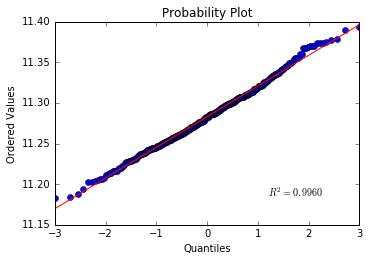

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
scipy.stats.probplot(mean_scores, dist='norm', plot=plt)
plt.show()

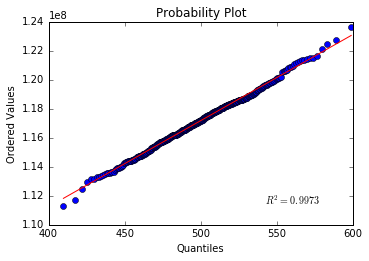

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(len(control_boot_chi_squared) - 1), plot=plt)
plt.show()

* $R^2$ для выборочной суммы квадратов отклонения от выборочной суммы получился меньше, чем 0.99
    (FALSE)

* $R^2$ для выборочного среднего получился больше, чем 0.99
    (TRUE)

* $R^2$ для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99
    (TRUE)

* $R^2$ для выборочного среднего получился меньше, чем 0.99
    (FALSE)

### Question 5

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [20]:
from collections import namedtuple
MannwhitneyuResult = namedtuple('MannwhitneyuResult', ('statistic', 'pvalue'))

def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    if alternative is None:
        warnings.warn("Calling `mannwhitneyu` without specifying "
                      "`alternative` is deprecated.", DeprecationWarning)

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = scipy.stats.rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")
    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = scipy.stats.distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * scipy.stats.distributions.norm.sf(abs(z))
    else:
        p = scipy.stats.distributions.norm.sf(z)
    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
    return MannwhitneyuResult(u, p)

In [21]:
n_clicks_exp_by_user = data_exp.groupby(by='userID')['n_clicks'].agg(np.sum)
n_click_control_by_user = data_control.groupby(by='userID')['n_clicks'].agg(np.sum)

In [22]:
mannwhitneyu(n_clicks_exp_by_user, n_click_control_by_user, alternative='two-sided')

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.6942943775208786e-75)

* Критерий Манна-Уитни в данной задаче применять нельзя, поэтому вопрос о достигаемом уровне значимости некорректен (FALSE)

* Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками (TRUE)

* $p<0.01$, поэтому можно сказать, что отличия незначительны на уровне доверия 0.05 (FALSE)

* Согласно полученному значению p-value, мы вынуждены принять нулевую гипотезу (FALSE)

### Question 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [23]:
data.browser.value_counts()

Browser #4     156833
Browser #22    142905
Browser #2     110737
Browser #14     89123
Browser #20     33929
Browser #17     32607
Name: browser, dtype: int64

In [24]:
p_values = np.array([])

for browser_id in data.browser.unique():
    mannwhitneyutest = mannwhitneyu(data_exp[data_exp.browser == browser_id]['n_clicks'], 
                                    data_control[data_control.browser == browser_id]['n_clicks'],
                                    alternative='two-sided')

    p_values = np.append(p_values, mannwhitneyutest.pvalue)

In [25]:
p_values

array([ 0.05448772,  0.81521235,  0.        ,  0.0748012 ,  0.90733313,
        0.51481103])

In [26]:
reject, p_corrected, a1, a2 = multipletests(p_values, alpha = 0.05, method = 'holm')

In [27]:
print data.browser.unique()
print reject
print p_corrected

['Browser #2' 'Browser #4' 'Browser #14' 'Browser #17' 'Browser #20'
 'Browser #22']
[False False  True False False False]
[ 0.2724386   1.          0.          0.29920481  1.          1.        ]


In [28]:
print "answer: " , len(reject[reject == False])

answer:  5


### Question 7

Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [29]:
for browser_id in data.browser.unique():
    non_click_queries_exp = np.sum(data_exp[data_exp.browser == browser_id].n_nonclk_queries)
    click_queries_exp = np.sum(data_exp[data_exp.browser == browser_id].n_clicks)
    
    non_click_queries_control = np.sum(data_control[data_control.browser == browser_id].n_nonclk_queries)
    click_queries_control = np.sum(data_control[data_control.browser == browser_id].n_clicks)
    
    
    non_click_part_exp = float(non_click_queries_exp) / click_queries_exp * 100
    non_click_part_control = float(non_click_queries_control) / click_queries_control * 100
    
    print browser_id, ": exp part = ", non_click_part_exp, "   control part = ", non_click_part_control

Browser #2 : exp part =  44.0117905622    control part =  45.9850803231
Browser #4 : exp part =  43.1076633978    control part =  46.8110053129
Browser #14 : exp part =  41.9804723041    control part =  77.813433448
Browser #17 : exp part =  29.1469665959    control part =  28.4319091823
Browser #20 : exp part =  32.7034388832    control part =  34.7715994458
Browser #22 : exp part =  34.4926898235    control part =  35.8566054034


* По всем браузерам мы видим незначительное уменьшение доли некликнутых запросов, поэтому делаем вывод о том, что тестируемое изменение приносит больше вреда, чем пользы. (FALSE)

* По одному из браузеров мы видим значительное уменьшение доли некликнутых запросов, поэтому уже только на этом основании тестируемое изменение можно рекомендовать к применению для всех пользователей. (FALSE)

* С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно. (TRUE)

* Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей. (FALSE)